In [512]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [513]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


<Axes: xlabel='대출 상환 기간', ylabel='count'>

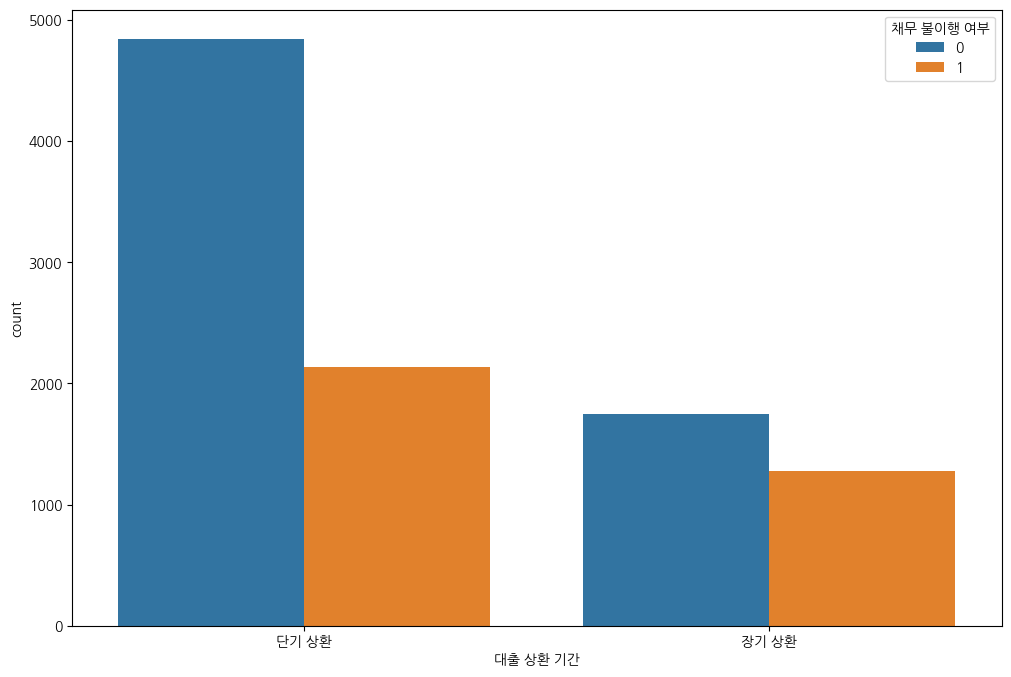

In [514]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.countplot(x = "대출 상환 기간", hue = "채무 불이행 여부", data = train_df)

In [515]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))
    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["연체 이후 경과 개월 분위수"] = pd.qcut(df["마지막 연체 이후 경과 개월 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["채무 이행 의지 없음"] = ((df["월 상환 부채액"] == 0) & (df["대출액+신용액"] > 0)).astype(int)
    

    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"]))* 100

    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DTR변형"] = (((df["월 상환 부채액"] + 1)) / (df["연간 소득"]/ 12)) * 100

    df["DTI분위"] = pd.qcut(df["DTI"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["DTR분위"] = pd.qcut(df["DTR변형"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    #df["DTI vs DTR"] = (df["DTR변형"] - df["DTI"])
    df["DBI"] = (df["DTI"] + df["DTR변형"]) / 2
    df["DRS"] = (df["DTI"] * df["DTR변형"])

    df["신용위험"] = ((df["개설된_신용계좌_분위수"] >= 3) & (df["신용점수분위"] <= 3) & (df["신용거래분위"] <= 3)).astype(int)
    df["소득위험"] = ((df["직장근속연수 분위수"] < 3) & (df["연간소득분위"] < 3)).astype(int)
    df["대출위험"] = ((df["상환액 분위"] > 3) & (df["DTR분위"] < 3)).astype(int)
    df["파산위험"] = ((df["신용 문제 발생 횟수"] > 0) & ((df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0))).astype(int)
    df["부채통합위험"] = ((df["대출 목적"] == 4) & (df["DTI분위"] > 3)).astype(int)
    df["부채통합위험2"] = ((df["대출 목적"] == 4) & (df["신용위험"] == 1)).astype(int)
    df["장기상환위험"] = ((df["대출 상환 기간"] == 1) & (df["신용점수분위"] < 3)).astype(int)
    df["연체위험"] = ((df["연체 이후 경과 개월 분위수"] < 3) & df["장기상환위험"] == 1).astype(int)
    

    df["위험분자"] = df["신용위험"] + df["소득위험"] + df["대출위험"] + df["파산위험"] + df["부채통합위험"] + df["부채통합위험2"] + df["채무 이행 의지 없음"] + df["장기상환위험"] + df["연체위험"]


    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100


    #df["위험도 점수"] = df["신용점수분위"] - df["상환액 분위"]
    #df["위험도 점수2"] = df["신용거래분위"] - df["개설된_신용계좌_분위수"]
    #df["위험도 점수3"] = df["직장근속연수 분위수"] - df["대출잔액 분위수"]

    #df["문제 발생 점수"] = df["신용 문제 발생 횟수"] + df["개인 파산 횟수"] + df["체납 세금 압류 횟수"]


    #df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용점수분위"] > 3)).astype(int)


    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1) * 100
 


    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    #df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    신용대출 = df.groupby("개설된 신용계좌 수")["현재 대출 잔액"].agg("mean")
    #df["신용계좌vs대출잔액"] = df["개설된 신용계좌 수"].map(신용대출)
    #df["신용계좌vs대출잔액"] = df["신용계좌vs대출잔액"] / 10000
    
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)  

    df = df.drop(["대출액+신용액", "DTR분위", "상환액 분위", "DTI분위"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,소득위험,대출위험,파산위험,부채통합위험,부채통합위험2,장기상환위험,연체위험,위험분자,근속연수vs거래연수,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,0,0,0,0,0,0,0,0,76.923077,36.000000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,0,0,0,1,0,0,0,1,66.666667,41.666667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,1,0,1,1,0,0,0,3,22.222222,16.000000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,0,0,1,1,0,0,0,2,42.857143,65.217391
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,0,1,0,0,0,0,0,1,7.692308,33.333333


In [516]:
train["DTR변형"].describe()

count    10000.000000
mean        14.114465
std          9.648202
min          0.000290
25%          7.318940
50%         12.078001
75%         18.740049
max         86.917714
Name: DTR변형, dtype: float64

<Axes: xlabel='연체 이후 경과 개월 분위수', ylabel='count'>

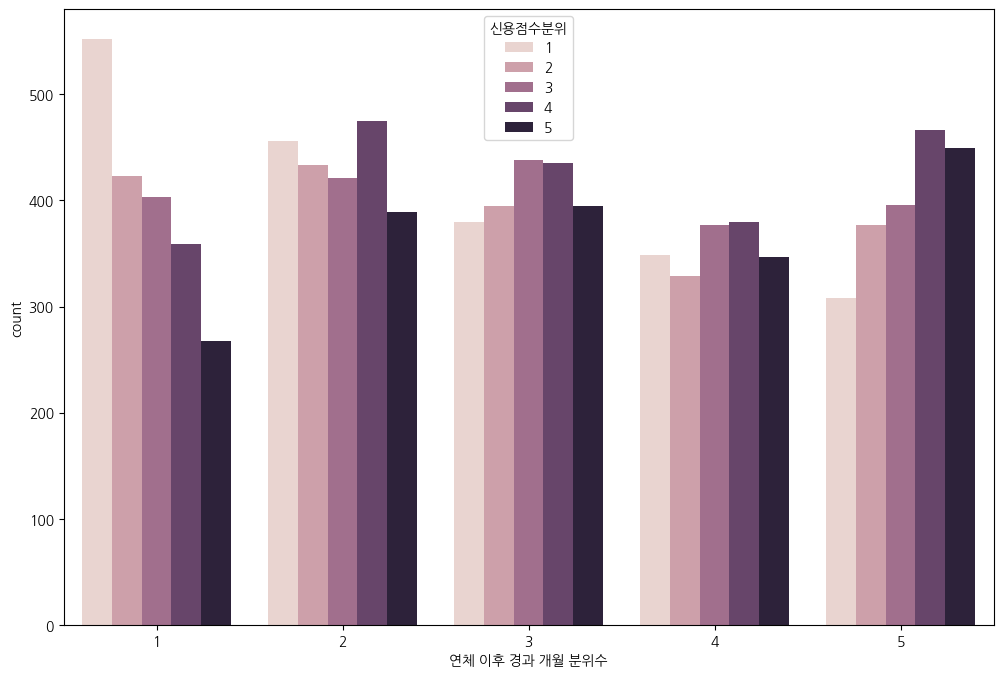

In [517]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.countplot(x = "연체 이후 경과 개월 분위수", hue = "신용점수분위", data = train)

In [518]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["최대 신용한도", "연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "근속연수vs거래연수", "신용한도vs대출잔액", "신용 점수", "DTI", "DTR변형", "DBI", "DRS", "개설계좌vs연체이후개월수", "개설된 신용계좌 수", "신용 거래 연수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   최대 신용한도        10000 non-null  float64
 1   연간 소득          10000 non-null  float64
 2   월 상환 부채액       10000 non-null  float64
 3   현재 대출 잔액       10000 non-null  float64
 4   현재 미상환 신용액     10000 non-null  float64
 5   근속연수vs거래연수     10000 non-null  float64
 6   신용한도vs대출잔액     10000 non-null  float64
 7   신용 점수          10000 non-null  float64
 8   DTI            10000 non-null  float64
 9   DTR변형          10000 non-null  float64
 10  DBI            10000 non-null  float64
 11  DRS            10000 non-null  float64
 12  개설계좌vs연체이후개월수  10000 non-null  float64
 13  개설된 신용계좌 수     10000 non-null  float64
 14  신용 거래 연수       10000 non-null  float64
dtypes: float64(15)
memory usage: 1.1 MB
None


In [519]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [520]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int32  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int32  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  float64
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int32  
 11  대출 상환 기간           10000 non-null  int32  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  신용거래분위             1000

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


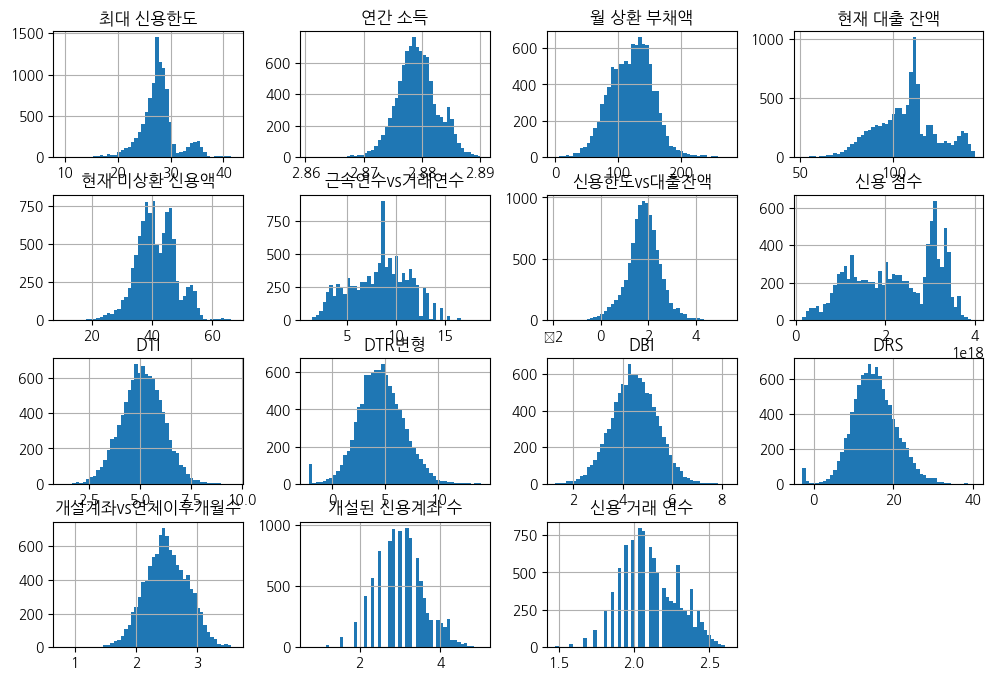

In [521]:
import matplotlib.font_manager as fm

plt.rc("font", family = "NanumGothic")

train[cols].hist(figsize = (12,8), bins = 50);

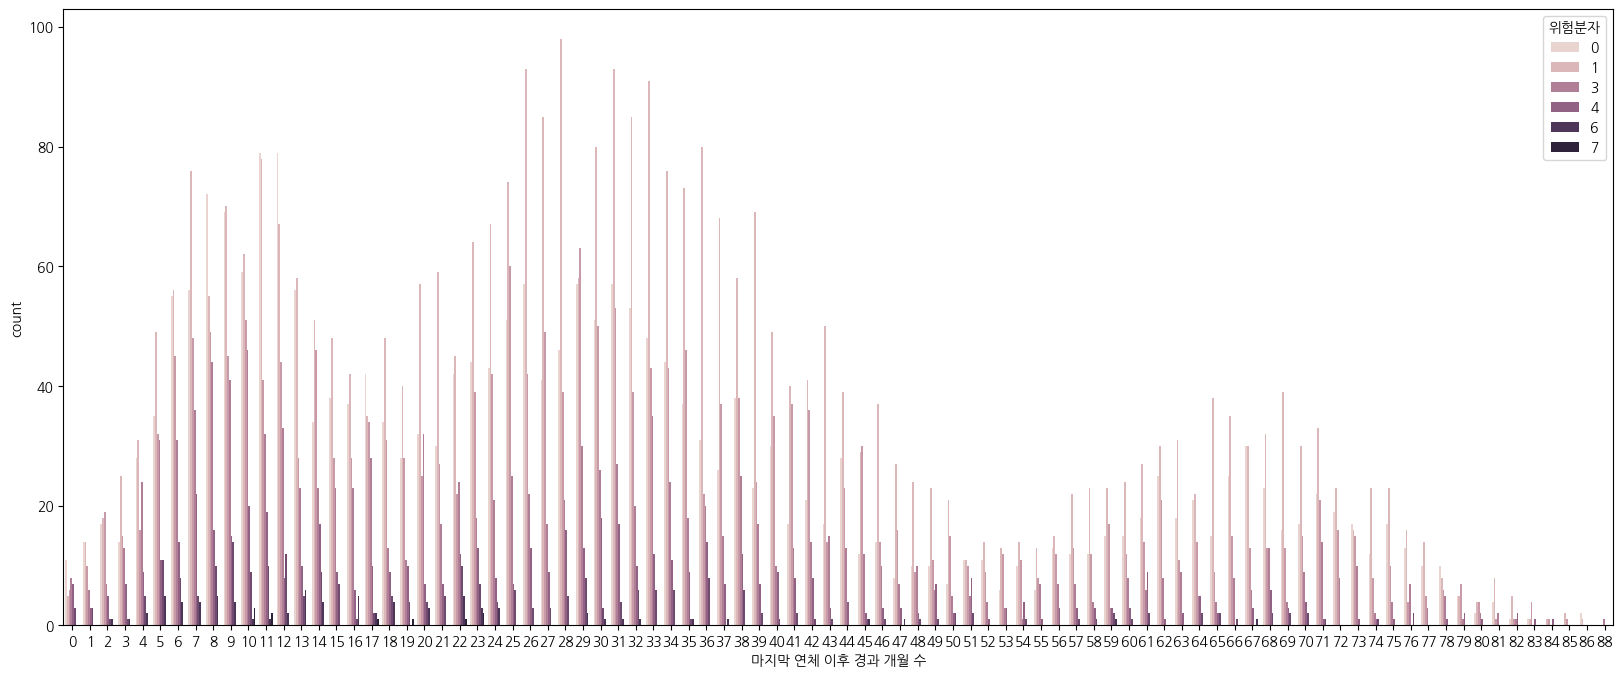

In [522]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize = (20,8))
sns.countplot(x = "마지막 연체 이후 경과 개월 수", hue = "위험분자", data = train)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:0001.0f}'))
plt.show()

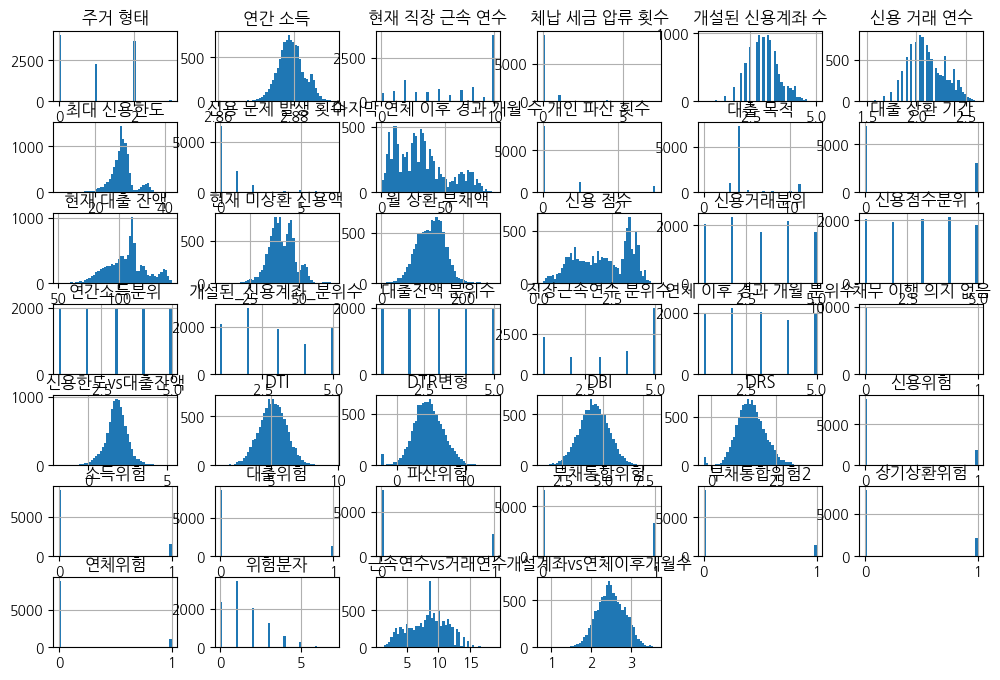

In [523]:
train.hist(figsize = (12,8),bins = 50);

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()


<Axes: >

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


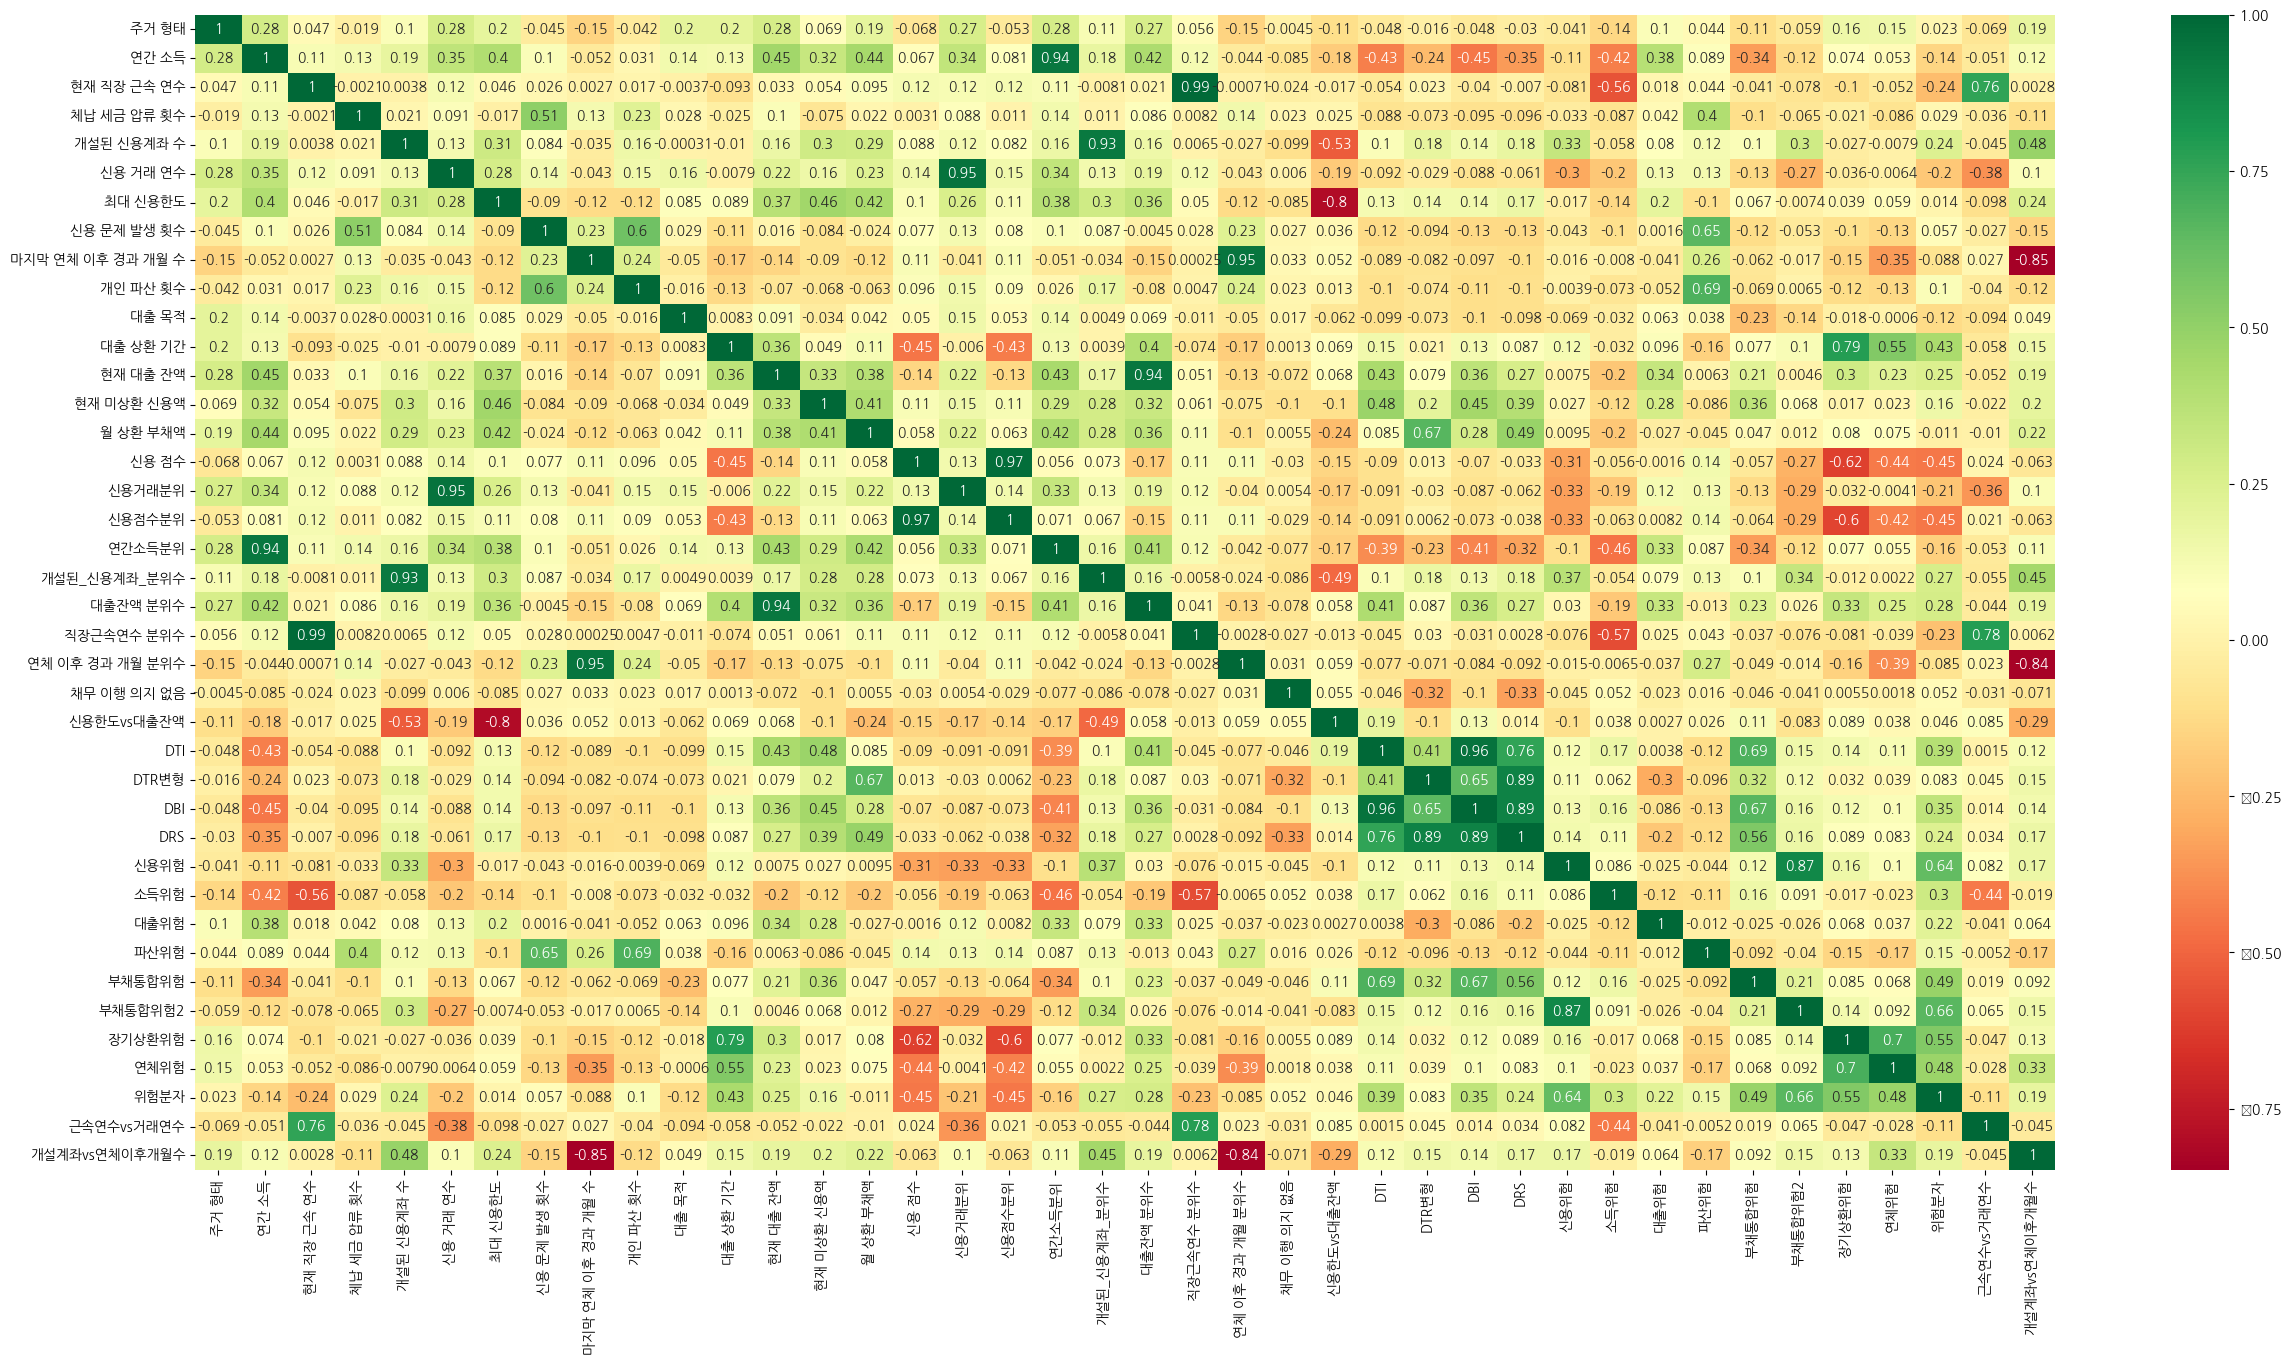

In [524]:
corrmat = train.corr()
corr_cols = corrmat.index[abs(corrmat["위험분자"] >= 0.1)]
plt.figure(figsize = (30,15))
sns.heatmap(train.corr(), annot = True, cmap = "RdYlGn")

In [525]:
train[cols].describe()

,최대 신용한도,연간 소득,월 상환 부채액,현재 대출 잔액,현재 미상환 신용액,근속연수vs거래연수,신용한도vs대출잔액,신용 점수,DTI,DTR변형,DBI,DRS,개설계좌vs연체이후개월수,개설된 신용계좌 수,신용 거래 연수
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27.687612,2.879252,121.469908,106.947209,41.396724,8.320381,1.812153,2.213053e+18,5.124920,4.610765,4.463582,15.309022,2.498622,3.091183,2.132955
std,3.441236,0.003492,34.254658,16.404588,6.755067,3.017711,0.721252,9.150231e+17,1.033056,2.201255,0.917234,5.562989,0.348053,0.589468,0.185377
min,9.454365,2.860570,0.439571,50.907395,10.036393,1.052152,-1.885354,1.460260e+17,1.172243,-2.196398,1.283185,-2.857120,0.795464,0.739144,1.478490
25%,26.055129,2.877004,96.981417,95.956774,36.999796,6.105500,1.418606,1.388818e+18,4.442472,3.194370,3.857990,11.667706,2.266837,2.706044,1.997558
50%,27.682038,2.879109,123.272652,108.435283,40.928808,8.522790,1.827222,2.232445e+18,5.130484,4.548773,4.459851,15.092458,2.487169,3.148094,2.118524
75%,29.031378,2.881363,145.131711,115.023128,45.863310,10.529483,2.230454,3.068984e+18,5.820123,6.010768,5.086367,18.776659,2.742908,3.507406,2.280443
max,42.084575,2.890255,275.743292,143.795523,67.417392,18.753989,5.330435,3.994169e+18,9.639172,14.056910,8.246125,40.522916,3.605826,5.013910,2.623394


In [526]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int32  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int32  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  float64
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int32  
 11  대출 상환 기간           10000 non-null  int32  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  신용거래분위             1000

In [527]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)
"""
standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

In [528]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4949 - loss: 0.7184 - val_accuracy: 0.5027 - val_loss: 0.7022
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4966 - loss: 0.7051 - val_accuracy: 0.5156 - val_loss: 0.6924
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5112 - loss: 0.6959 - val_accuracy: 0.5406 - val_loss: 0.6861
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5240 - loss: 0.6921 - val_accuracy: 0.5778 - val_loss: 0.6809
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5323 - loss: 0.6891 - val_accuracy: 0.6112 - val_loss: 0.6759
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5516 - loss: 0.6836 - val_accuracy: 0.6290 - val_loss: 0.6714
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5578 - loss: 0.6836 - val_accuracy: 0.6366 - val_loss: 0.6671
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5713 - loss: 0.6796 - val_accuracy: 0.6449

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5044 - loss: 0.6961 - val_accuracy: 0.5431 - val_loss: 0.6889
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5192 - loss: 0.6918 - val_accuracy: 0.5806 - val_loss: 0.6848
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5457 - loss: 0.6869 - val_accuracy: 0.5871 - val_loss: 0.6810
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5567 - loss: 0.6832 - val_accuracy: 0.5947 - val_loss: 0.6772
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5725 - loss: 0.6802 - val_accuracy: 0.6023 - val_loss: 0.6737
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5860 - loss: 0.6749 - val_accuracy: 0.6080 - val_loss: 0.6702
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5869 - loss: 0.6751 - val_accuracy: 0.6102 - val_loss: 0.6666
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5894 - loss: 0.6721 - val_accuracy: 0.6167

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5018 - loss: 0.7097 - val_accuracy: 0.4960 - val_loss: 0.6989
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5065 - loss: 0.6973 - val_accuracy: 0.4998 - val_loss: 0.6924
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4998 - loss: 0.6946 - val_accuracy: 0.5150 - val_loss: 0.6880
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5222 - loss: 0.6907 - val_accuracy: 0.5514 - val_loss: 0.6844
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5458 - loss: 0.6867 - val_accuracy: 0.5898 - val_loss: 0.6810
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5411 - loss: 0.6855 - val_accuracy: 0.6095 - val_loss: 0.6774
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5722 - loss: 0.6806 - val_accuracy: 0.6194 - val_loss: 0.6739
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5680 - loss: 0.6774 - val_accuracy: 0.6231

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4945 - loss: 0.7049 - val_accuracy: 0.5192 - val_loss: 0.6924
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4991 - loss: 0.7004 - val_accuracy: 0.5465 - val_loss: 0.6864
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5305 - loss: 0.6915 - val_accuracy: 0.5757 - val_loss: 0.6812
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5434 - loss: 0.6873 - val_accuracy: 0.5871 - val_loss: 0.6766
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5624 - loss: 0.6817 - val_accuracy: 0.5951 - val_loss: 0.6726
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5655 - loss: 0.6800 - val_accuracy: 0.6023 - val_loss: 0.6689
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5800 - loss: 0.6770 - val_accuracy: 0.6061 - val_loss: 0.6652
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5923 - loss: 0.6703 - val_accuracy: 0.6102

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4927 - loss: 0.7226 - val_accuracy: 0.5032 - val_loss: 0.7000
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4892 - loss: 0.7086 - val_accuracy: 0.5025 - val_loss: 0.6933
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5091 - loss: 0.6967 - val_accuracy: 0.5180 - val_loss: 0.6889
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5259 - loss: 0.6904 - val_accuracy: 0.5613 - val_loss: 0.6855
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5325 - loss: 0.6899 - val_accuracy: 0.6008 - val_loss: 0.6821
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5464 - loss: 0.6874 - val_accuracy: 0.6247 - val_loss: 0.6786
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5542 - loss: 0.6831 - val_accuracy: 0.6319 - val_loss: 0.6751
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5784 - loss: 0.6785 - val_accuracy: 0.6368

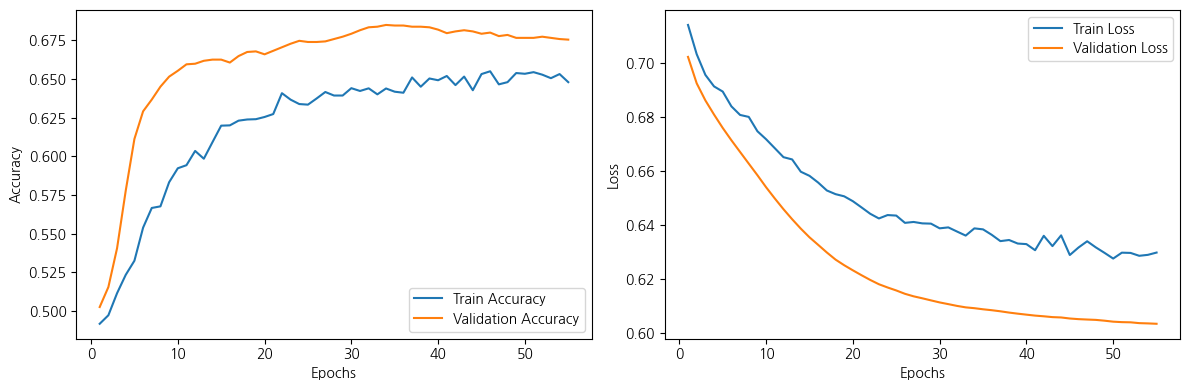

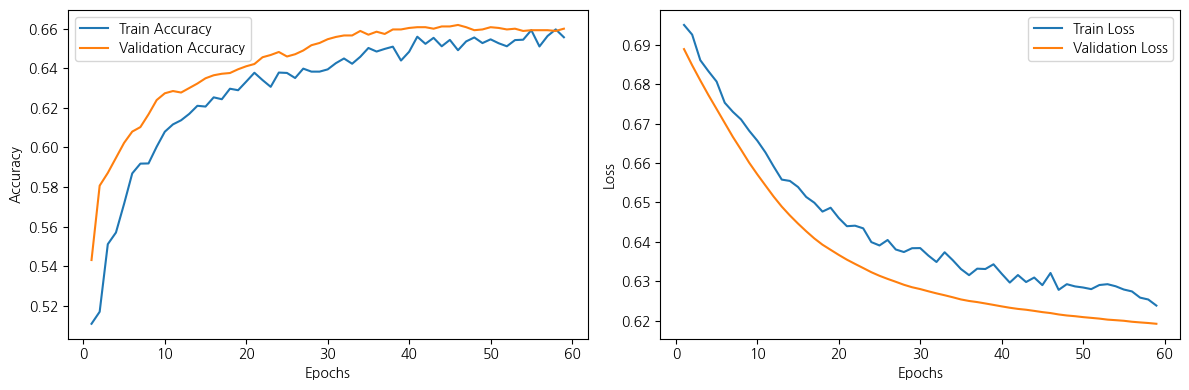

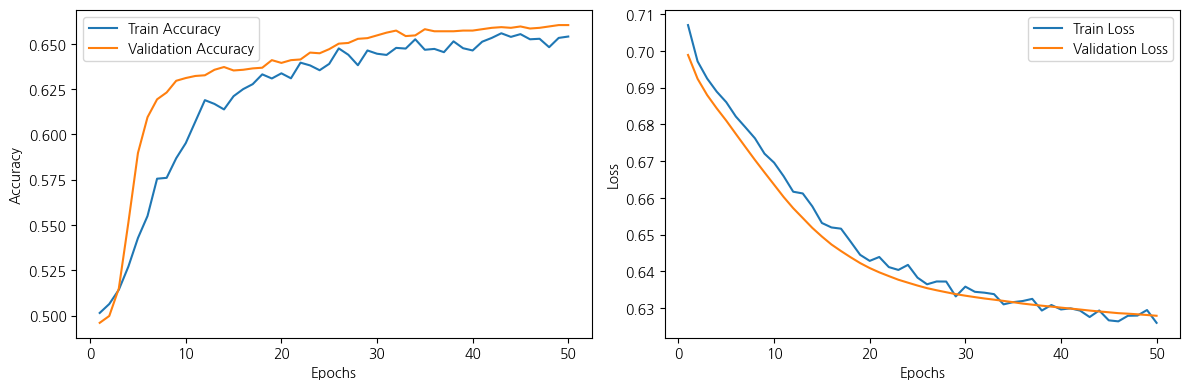

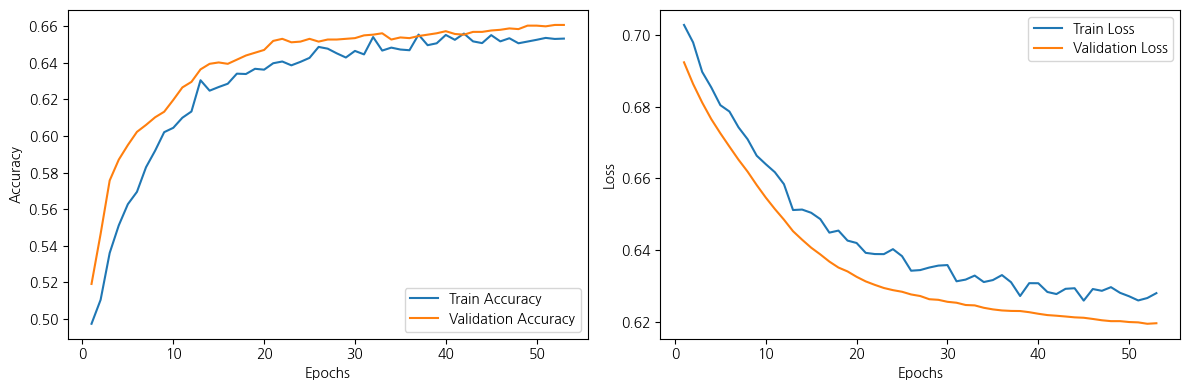

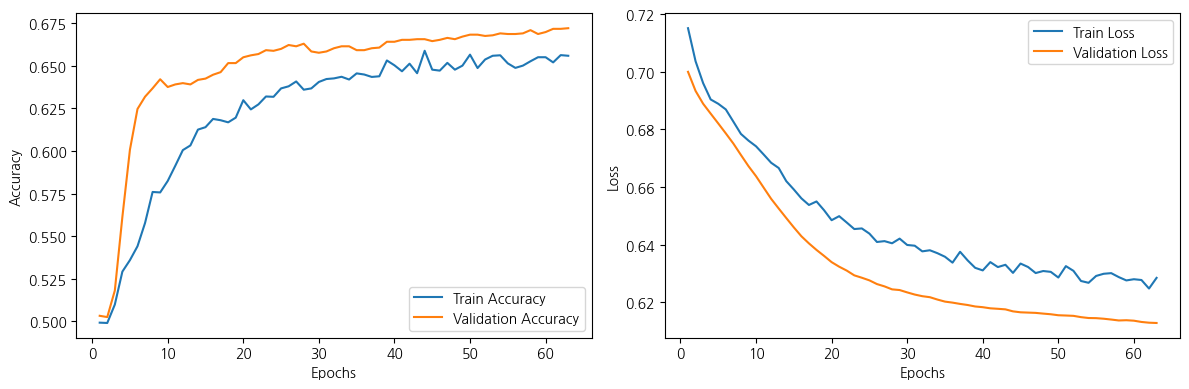

In [529]:
all_history = []
kf = KFold(n_splits = 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        batch_size = 32,
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [530]:
pred = model.predict(test_scaled).ravel()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


In [531]:
pred = model.predict(test_scaled).ravel()

sub_path = os.path.join(file_path, "데이터셋", "sample_submission.csv")
submission1 = pd.read_csv(sub_path)

submission1["채무 불이행 확률"] = pred * 100
submission1.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission11.csv", index = False) 

"""
submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100 })
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission10.csv", index = False)
"""
submission1.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


,UID,채무 불이행 확률
0,TEST_0000,57.716061
1,TEST_0001,40.577732
2,TEST_0002,41.377777
3,TEST_0003,30.596378
4,TEST_0004,45.722702
